In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import pdal
from dask.distributed import Client

np.set_printoptions(precision=4, suppress=True)

from forest_structure_tools.metrics import forest_structure_metrics, cover_metrics

In [2]:
data_dir = Path("../data")
plots_dir = data_dir / "outputs" / "plots"
plots_lidar_dir = plots_dir / "lidar"

plots_gdf = gpd.read_file(plots_dir / "plots.geojson")
plot_ids = plots_gdf['id'].to_list()

def read_plot_lidar(plot_id: str):
    pl = pdal.Reader(str(plots_lidar_dir / f"{plot_id}.copc.laz")).pipeline()
    pl.execute()

    return pl.arrays[0]

In [3]:
def add_plot_dimension_to_ds(ds: xr.Dataset, plot_id: str) -> xr.Dataset:
    site = plot_id[:-3]
    site_type = site[:3]

    ds = ds.expand_dims(plot=[plot_id]).assign_coords(
        plot=("plot", [plot_id]), site=("plot", [site]), site_type=("plot", [site_type])
    )

    return ds

In [4]:
def add_suffix(ds: xr.Dataset, suffix: str):
    new_names = {var: var + suffix for var in ds.data_vars}
    ds_suffixed = ds.rename(new_names)
    return ds_suffixed

def add_prefix(ds: xr.Dataset, prefix: str):
    new_names = {var: prefix + var for var in ds.data_vars}
    ds_prefixed = ds.rename(new_names)
    return ds_prefixed


In [14]:
def calculate_metrics(plot_id: id):
    points = read_plot_lidar(plot_id)
    x = points["X"]
    y = points["Y"]
    z = points["Z"]

    weights = 1 / points["NumberOfReturns"]

    # Standard set
    standard_metrics = forest_structure_metrics(
        x=x,
        y=y,
        z=z,
        include_basic=True,
        cover_threshold=0,
        percentiles=np.arange(10, 100, 10),
        xy_bin_size=0.5,
        z_bin_size=1,
        weights=None
    )

    return standard_metrics


In [15]:
metrics = calculate_metrics("AGG_O_01_P1")

/Users/jgregory/Code/forest-structure-tools/forest_structure_tools/metrics.py:122: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_veg = skew(veg_z)
/Users/jgregory/Code/forest-structure-tools/forest_structure_tools/metrics.py:123: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_veg = kurtosis(veg_z)


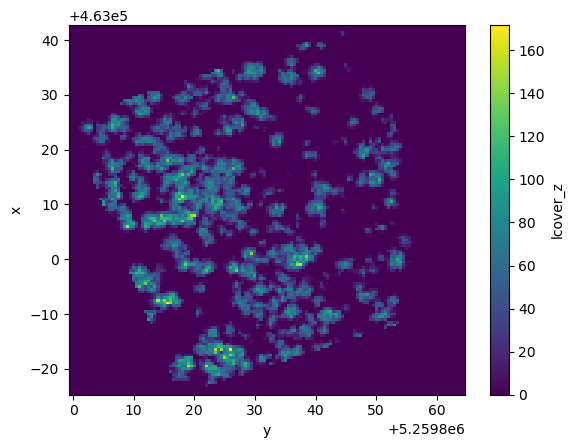

In [32]:
metrics['lcover_z'].sel(z=slice(10, None)).sum(dim='z').plot()

In [13]:
metrics

<xarray.Dataset> Size: 3MB
Dimensions:     (x: 135, y: 131)
Coordinates:
  * x           (x) float64 1kB 4.63e+05 4.63e+05 4.63e+05 ... 4.63e+05 4.63e+05
  * y           (y) float64 1kB 5.26e+06 5.26e+06 5.26e+06 ... 5.26e+06 5.26e+06
Data variables: (12/23)
    max_veg     (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    mean_veg    (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    median_veg  (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    sd_veg      (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    var_veg     (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    cv_veg      (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    ...          ...
    q80_veg     (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    q90_veg     (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    lgap        (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    lcover      (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    pai         (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
    pad         (x, y) float64 141kB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    xy_bin_size:  0.5
    z_bin_size:   None

In [9]:
(metrics['lcover_z'].sum() / 100, metrics['pai'])

(<xarray.DataArray 'lcover_z' ()> Size: 8B
 array(54.4853),
 <xarray.DataArray 'pai' (x: 8, y: 8)> Size: 512B
 array([[   nan,    nan, 7.0211, 2.6133,    nan,    nan,    nan,    nan],
        [   nan,    nan, 1.5684, 1.9388, 1.7341, 1.993 , 1.4919,    nan],
        [   nan, 1.1664, 1.8166, 1.7454, 2.1233, 1.4637, 1.4337, 1.274 ],
        [   nan, 0.9732, 1.4246, 1.7983, 1.5283, 1.0986, 1.218 , 1.771 ],
        [   nan, 1.9131, 2.2049, 1.5579, 1.3729, 1.3276, 1.3871,    nan],
        [0.    , 1.9804, 1.8454, 1.3959, 1.2908, 1.2028, 1.8634,    nan],
        [   nan,    nan, 1.5535, 1.7488, 1.1516, 1.0873, 2.4036,    nan],
        [   nan,    nan,    nan,    nan, 1.135 , 1.4094,    nan,    nan]])
 Coordinates:
   * x        (x) float64 64B 4.63e+05 4.63e+05 4.63e+05 ... 4.63e+05 4.63e+05
   * y        (y) float64 64B 5.26e+06 5.26e+06 5.26e+06 ... 5.26e+06 5.26e+06)

In [10]:
# def calculate_metrics(plot_id: id, xy_bin_size: float | None = None, z_bin_size: float | None = 1, z_bin_count: float | None = 10, weighted = False):
#     points = read_plot_lidar(plot_id)
#     x = points["X"]
#     y = points["Y"]
#     z = points["Z"]

#     if weighted:
#         weights = 1 / points["NumberOfReturns"]
#     else:
#         weights = None

#     metrics = forest_structure_metrics(x=x, y=y, z=z, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size, z_bin_count=z_bin_count, weights=weights)


#     if xy_bin_size is not None:
#         x_offset = metrics.x.min().item()
#         y_offset = metrics.y.min().item()

#         metrics['x_offset'] = x_offset
#         metrics['y_offset'] = y_offset

#         metrics['x'] = metrics['x'] - x_offset
#         metrics['y'] = metrics['y'] - y_offset


#     metrics = add_plot_dimension_to_ds(metrics, plot_id)

#     metrics.attrs["xy_bin_size"] = str(xy_bin_size)
#     metrics.attrs["z_bin_size"] = str(z_bin_size)
#     metrics.attrs["weighted"] = str(weighted)
    
#     return metrics